# RothC
This notebook presents an implementation of RothC (*RothC - A model for the turnover of carbon in soil*) based on the model description and users guide (updated 2014) available online [here](https://www.rothamsted.ac.uk/rothamsted-carbon-model-rothc). This implementation also cites:
* The R package *SoilR* available online [here](https://cran.r-project.org/web/packages/SoilR/index.html).
* SoilR workflows described in Theoretical Ecosystem Ecology available online [here](https://www.bgc-jena.mpg.de/TEE/software/soilr/).
* The Technical Manual for the Global Soil Organic Carbon Sequestration Potential Map (GSOCseq) by the FAO, which also describes the RothC model and it's implementation in R, available online [here](https://fao-gsp.github.io/GSOCseq/index.html#github-page).

In [10]:
import os
import sys
ROOT_DIR = os.getcwd()
if ROOT_DIR + "/src" not in sys.path: sys.path.append(ROOT_DIR + "/src")
import numpy as np
from numpy import array as a
import cfasoc.builders as bd
from cfasoc.climate import ClimateDataSampled, DemoClimateData, ClimateDataFromAPI
import cfasoc.rothc.model as m
import test.rothc.test_model as test # type: ignore
import cfasoc.rothc.equations as eq

## Test against SoilR
Run the implementation of RothC (this package) against model outputs produced using SoilR. Plot these results to show fit, with the SoilR results shown in blue and the calculated results shown in red. 

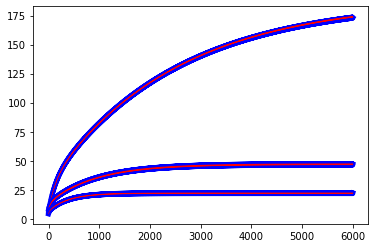

In [3]:
test.test_run(plot=True)

# Example 1
Run the model using the IPCC demo climate data.

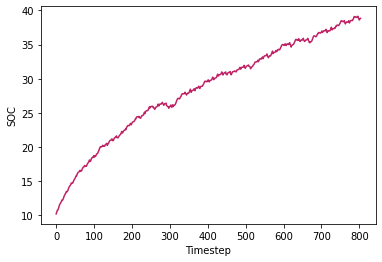

In [4]:
ipcc_climate = DemoClimateData()
months = int(len(ipcc_climate.years))
iters = 1
c_input = bd.repeat_single(shape=(months,iters), value = 0.25)
vegetated = bd.repeat_single_bool(shape=(months,iters), value=False)
fym = bd.repeat_single(shape=(months,iters),value=0)
init_iom = a([10])

rmf_a = m.calc_rmf_a(temperature=ipcc_climate.temp)
rmf_b = m.calc_rmf_b(precip=ipcc_climate.rain,pet=ipcc_climate.pet,vegetated=vegetated)
rmf_c = m.calc_rmf_c(vegetated=vegetated)

res = m.run(c_input=c_input, rmf_a=rmf_a, rmf_b=rmf_b,rmf_c=rmf_c, fym=fym, init_iom=init_iom)
res.plot_percentile(variable="soc", percentile=50)

## Example 2
Run the model for a a single iteration and default model values.

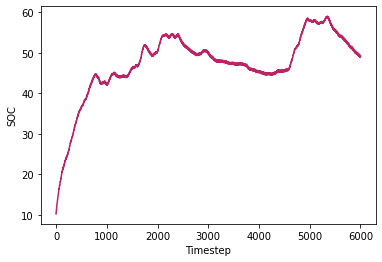

In [5]:
years = 500
months = years * 12
iters = 1
climate = ClimateDataSampled(climate_data=ipcc_climate, years=years, iters=iters)

c_input = bd.repeat_single(shape=(months,iters), value = 0.25)
vegetated = bd.repeat_single_bool(shape=(months,iters), value=False)
fym = bd.repeat_single(shape=(months,iters),value=0)
init_iom = a([10])

rmf_a = m.calc_rmf_a(temperature=climate.temp)
rmf_b = m.calc_rmf_b(precip=climate.rain,pet=climate.pet,vegetated=vegetated)
rmf_c = m.calc_rmf_c(vegetated=vegetated)

res = m.run(c_input=c_input, rmf_a=rmf_a, rmf_b=rmf_b,rmf_c=rmf_c, fym=fym, init_iom=init_iom)
res.plot_percentile(variable="soc", percentile=50)

## Example 3
Run the model for multiple iterations and default model values.

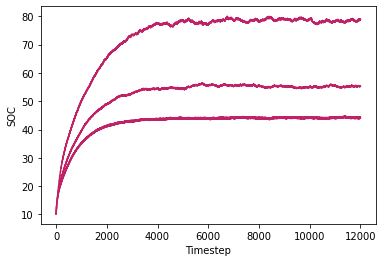

In [6]:
years = 1000
months = years * 12
iters = 1000
climate = ClimateDataSampled(climate_data=ipcc_climate, years=years, iters=iters)

c_input = bd.repeat_single(shape=(months,iters), value = 0.25)
vegetated = bd.repeat_single_bool(shape=(months,iters), value=False)
fym = bd.repeat_single(shape=(months,iters),value=0)

rmf_a = m.calc_rmf_a(temperature=climate.temp)
rmf_b = m.calc_rmf_b(precip=climate.rain,pet=climate.pet,vegetated=vegetated)
rmf_c = m.calc_rmf_c(vegetated=vegetated)

res = m.run(c_input=c_input, rmf_a=rmf_a, rmf_b=rmf_b,rmf_c=rmf_c, fym=fym, init_iom=init_iom)
res.plot_percentile(variable="soc", percentile=(2.5, 50, 97.5))

## Example 4
Run the model but with two different periods of carbon input generated from two different distributions, which are then stacked. This approach can be used to model different practices.

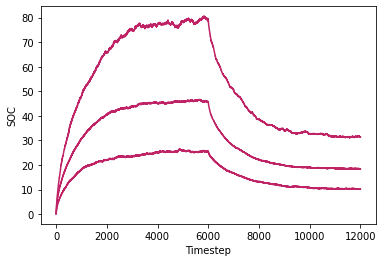

In [7]:
half_months = int(months/2)
c_input_1 = bd.normal_1d(shape=(half_months,iters),mu=0.25,sigma=0.05)
c_input_2 = bd.normal_1d(shape=(half_months,iters),mu=0.1,sigma=0.02)
c_input = bd.stack_arrays([c_input_1, c_input_2])

res = m.run(c_input=c_input, rmf_a=rmf_a, rmf_b=rmf_b,rmf_c=rmf_c, fym=fym)
res.plot_percentile(variable="soc", percentile=(2.5, 50, 97.5))

## Example 5
Run the model as for Example 3 but from an equilibrium determined using `spin_up`.

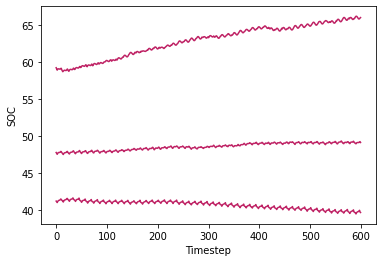

In [8]:
years = 50
months = years * 12
iters = 1000
climate = ClimateDataSampled(climate_data=ipcc_climate, years=years, iters=iters)

c_input = bd.repeat_single(shape=(months,iters), value = 0.25)
vegetated = bd.repeat_single_bool(shape=(months,iters), value=False)
fym = bd.repeat_single(shape=(months,iters),value=0)

rmf_a = m.calc_rmf_a(temperature=climate.temp)
rmf_b = m.calc_rmf_b(precip=climate.rain,pet=climate.pet,vegetated=vegetated)
rmf_c = m.calc_rmf_c(vegetated=vegetated)

equil = m.spin_up(c_input=c_input,rmf_a=rmf_a,rmf_b=rmf_b,rmf_c=rmf_c, fym=fym)
res = m.run(c_input=c_input, rmf_a=rmf_a, rmf_b=rmf_b,rmf_c=rmf_c, fym=fym, init_dpm=equil["DPM"], init_rpm=equil["RPM"], init_bio=equil["BIO"], init_hum=equil["HUM"], init_iom=equil["IOM"])
res.plot_percentile("soc", (2.5, 50, 97.5))

## Example 6
Run the model as for Example 4 but from an equilibrium determined using `spin_up`.

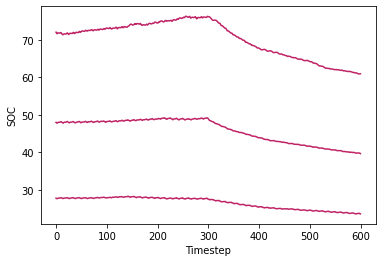

In [9]:
half_months = int(months/2)
c_input_1 = bd.normal_1d(shape=(half_months,iters),mu=0.25,sigma=0.05)
c_input_2 = bd.normal_1d(shape=(half_months,iters),mu=0.1,sigma=0.02)
c_input = bd.stack_arrays([c_input_1, c_input_2])

equil = m.spin_up(c_input=c_input,rmf_a=rmf_a,rmf_b=rmf_b,rmf_c=rmf_c, fym=fym)
res = m.run(c_input=c_input, rmf_a=rmf_a, rmf_b=rmf_b,rmf_c=rmf_c, fym=fym, init_dpm=equil["DPM"], init_rpm=equil["RPM"], init_bio=equil["BIO"], init_hum=equil["HUM"], init_iom=equil["IOM"])
res.plot_percentile(variable="soc", percentile=(2.5, 50, 97.5))